In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# --- Step 1: Setup and data loading ---

DATA_FILE = 'data/RESSET_GDQTTN_1.csv' 

SEQUENCE_LENGTH = 30 

BATCH_SIZE = 64

LR = 0.0001

AUTOENCODER_EPOCHS = 1000 
SUPERVISOR_EPOCHS = 1000 
GAN_EPOCHS         = 2000 

HIDDEN_DIM = 32         
NOISE_DIM  = HIDDEN_DIM   
NUM_LAYERS = 2

# 损失权重
GAMMA_SUP      = 5.0   
MOMENT_LAMBDA  = 0.1   


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load data
if not os.path.exists(DATA_FILE):
    print(f"'{DATA_FILE}' not found!")
    exit()

print(f"Load data: {DATA_FILE}")
data = pd.read_csv(DATA_FILE, index_col='TrdDt', parse_dates=True)

Load data: data/RESSET_GDQTTN_1.csv


In [5]:
# --- Step 2: Data preprocessing (TimeGAN uses [0, 1] normalization) ---
log_returns = np.log(data['ClPr'] / data['ClPr'].shift(1)).dropna().values.reshape(-1, 1)

# *** Key change: TimeGAN uses [0, 1] normalization ***
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(log_returns)

# Create sliding-window samples
sequences = []
for i in range(len(data_normalized) - SEQUENCE_LENGTH):
    sequences.append(data_normalized[i:i+SEQUENCE_LENGTH])
    
real_sequences = torch.FloatTensor(np.array(sequences)).to(device)
# [N, Seq_Len, Features] -> [N, 30, 1]
dataset = TensorDataset(real_sequences)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Data loaded, created {len(sequences)} training samples.")

Data loaded, created 2377 training samples.


In [6]:
# --- Step 3: TimeGAN model definition ---
# TimeGAN consists of 4 core components: Embedder, Recovery, Generator, Discriminator
# (The supervisor network is part of the embedder)

# 3.1 Encoder E (Embedder)
class Embedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Embedder, self).__init__()
        # Use GRU, which is slightly faster than LSTM
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    
    def forward(self, x):
        # x: [Batch, Seq_Len, Features]
        # H: [Batch, Seq_Len, Hidden_Dim]
        H, _ = self.rnn(x)
        return H

In [7]:
# 3.2 Recovery R (Recovery)
class Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        super(Recovery, self).__init__()
        self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid() # Used together with 0-1 normalization
    
    def forward(self, H):
        # H: [Batch, Seq_Len, Hidden_Dim]
        O, _ = self.rnn(H)
        X_tilde = self.fc(O)
        X_tilde_normalized = self.sigmoid(X_tilde) # Output reconstructed data
        return X_tilde_normalized

In [8]:
# 3.3 Generator G (Generator)
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim) # Output sequence in the latent space
    
    def forward(self, Z):
        # Z: [Batch, Seq_Len, Noise_Dim]
        E, _ = self.rnn(Z)
        E_hat = self.fc(E)
        return E_hat # H_hat

In [9]:
# 3.4 Discriminator D (Discriminator)
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super(Discriminator, self).__init__()
        self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, H):
        # H: [Batch, Seq_Len, Hidden_Dim]
        # We only need the output of the last time step
        O, _ = self.rnn(H)
        last_hidden = O[:, -1, :]
        Y_hat = self.fc(last_hidden)
        Y_hat_prob = self.sigmoid(Y_hat)
        return Y_hat_prob

In [10]:
# 3.5 Supervisor network S (Supervisor)
class Supervisor(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super(Supervisor, self).__init__()
        self.rnn = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, H):
        # H: [B, T, H]
        S_out, _ = self.rnn(H)
        H_hat = self.fc(S_out)
        return H_hat


In [11]:
# --- Initialize all models ---
embedder = Embedder(1, HIDDEN_DIM, NUM_LAYERS).to(device)
recovery = Recovery(HIDDEN_DIM, 1, NUM_LAYERS).to(device)
generator = Generator(NOISE_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
supervisor = Supervisor(HIDDEN_DIM, NUM_LAYERS).to(device)
discriminator = Discriminator(HIDDEN_DIM, NUM_LAYERS).to(device)

# --- Loss functions ---
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()


In [12]:
autoencoder_params = list(embedder.parameters()) + list(recovery.parameters())
optimizer_autoencoder = optim.Adam(autoencoder_params, lr=LR)

for epoch in tqdm(range(AUTOENCODER_EPOCHS), desc="Autoencoder Training", unit="epoch"):
    for (X,) in dataloader:
        optimizer_autoencoder.zero_grad()
        
        # Disable cuDNN to avoid potential errors
        with torch.backends.cudnn.flags(enabled=False):
            H = embedder(X)
            X_tilde = recovery(H)
        
        # Reconstruction loss (Reconstruction Loss)
        recon_loss = mse_loss(X, X_tilde)
        
        recon_loss.backward()
        optimizer_autoencoder.step()
        
    if (epoch + 1) % 500 == 0:
        print(f"\n[AE Epoch {epoch+1}/{AUTOENCODER_EPOCHS}] Recon Loss: {recon_loss.item():.6f}")

Autoencoder Training:  50%|███████████████████████████                           | 500/1000 [35:40<36:54,  4.43s/epoch]


[AE Epoch 500/1000] Recon Loss: 0.000000


Autoencoder Training: 100%|███████████████████████████████████████████████████| 1000/1000 [1:08:51<00:00,  4.13s/epoch]


[AE Epoch 1000/1000] Recon Loss: 0.000000


In [13]:
# --- Step 5: Phase 2 - train the supervisor network (S) ---
# Objective: S(E(X_t)) ≈ E(X_{t+1})
optimizer_E = optim.Adam(embedder.parameters(), lr=LR)
optimizer_S = optim.Adam(supervisor.parameters(), lr=LR)

for epoch in tqdm(range(SUPERVISOR_EPOCHS), desc="Supervisor Training", unit="epoch"):
    for (X,) in dataloader:
        optimizer_E.zero_grad()
        optimizer_S.zero_grad()

        with torch.backends.cudnn.flags(enabled=False):
            H = embedder(X)                 # [B, T, H]
            H_hat = supervisor(H)           # [B, T, H]

        # Use the first T-1 steps to predict the next T-1 steps of H
        sup_loss = mse_loss(H_hat[:, :-1, :], H[:, 1:, :])

        sup_loss.backward()
        optimizer_E.step()
        optimizer_S.step()

    if (epoch + 1) % 500 == 0:
        print(f"\n[Sup Epoch {epoch+1}/{SUPERVISOR_EPOCHS}] Sup Loss: {sup_loss.item():.6f}")

Supervisor Training:  50%|█████████████████████████▌                         | 500/1000 [30:05<30:06,  3.61s/epoch]


[Sup Epoch 500/1000] Sup Loss: 0.000000


Supervisor Training: 100%|████████████████████████████████████████████████| 1000/1000 [1:00:19<00:00,  3.62s/epoch]


[Sup Epoch 1000/1000] Sup Loss: 0.000000


In [32]:


# --- Step 6: Phase 3 - joint GAN training (improved version) ---

optimizer_GS = optim.Adam(
    list(generator.parameters()) + list(supervisor.parameters()),
    lr=LR
)
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR)
optimizer_E_R = optim.Adam(
    list(embedder.parameters()) + list(recovery.parameters()),
    lr=LR
)

D_losses = []
G_losses = []
ER_losses = []

for epoch in tqdm(range(GAN_EPOCHS), desc="GAN Training", unit="epoch"):
    for (X,) in dataloader:
        current_batch_size = X.size(0)

        # =======================
        # 1. discriminator
        # =======================
        optimizer_D.zero_grad()

        with torch.backends.cudnn.flags(enabled=False):
            H_real = embedder(X).detach()          # [B, T, H]
            H_real_sup = supervisor(H_real).detach()

            Z = torch.rand(
                current_batch_size,
                SEQUENCE_LENGTH,
                NOISE_DIM,
                device=device
            )
            E_hat = generator(Z)
            H_fake = supervisor(E_hat).detach()

        # score of D
        Y_real = discriminator(H_real)
        Y_real_sup = discriminator(H_real_sup)
        Y_fake = discriminator(H_fake)

        # D loss
        D_loss_real = bce_loss(Y_real, torch.ones_like(Y_real)) \
                    + bce_loss(Y_real_sup, torch.ones_like(Y_real_sup))
        D_loss_fake = bce_loss(Y_fake, torch.zeros_like(Y_fake))
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        optimizer_D.step()

        # =======================
        # 2.  G + S
        # =======================
        optimizer_GS.zero_grad()

        Z = torch.rand(
            current_batch_size,
            SEQUENCE_LENGTH,
            NOISE_DIM,
            device=device
        )

        with torch.backends.cudnn.flags(enabled=False):
            E_hat = generator(Z)       # [B, T, H]
            H_fake = supervisor(E_hat) # [B, T, H]
            Y_fake = discriminator(H_fake)

        # 2a. againest loss
        G_loss_adv = bce_loss(Y_fake, torch.ones_like(Y_fake))

        # 2b. 
        G_loss_sup = mse_loss(H_fake[:, :-1, :], H_fake[:, 1:, :])

        # 2c.
        with torch.backends.cudnn.flags(enabled=False):
            X_fake = recovery(H_fake)  # [B, T, 1]
        X_real = X                     # [B, T, 1]

        G_loss_mom = mse_loss(X_fake.mean(dim=0), X_real.mean(dim=0)) \
                   + mse_loss(X_fake.std(dim=0),  X_real.std(dim=0))

        G_loss = G_loss_adv + GAMMA_SUP * G_loss_sup + MOMENT_LAMBDA * G_loss_mom

        G_loss.backward()
        optimizer_GS.step()

        # =======================
        # 3.  Embedder + Recovery
        # =======================
        optimizer_E_R.zero_grad()

        with torch.backends.cudnn.flags(enabled=False):
            H = embedder(X)
            X_tilde = recovery(H)
            H_hat = supervisor(H)

        ER_loss = mse_loss(X, X_tilde) \
                + mse_loss(H_hat[:, :-1, :], H[:, 1:, :])

        ER_loss.backward()
        optimizer_E_R.step()

    # record + print loss（200 epoch）
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
    ER_losses.append(ER_loss.item())

    if (epoch + 1) % 200 == 0:
        print(
            f"\n[GAN Epoch {epoch+1}/{GAN_EPOCHS}] "
            f"D Loss: {D_loss.item():.4f}, "
            f"G Loss: {G_loss.item():.4f}, "
            f"E_R Loss: {ER_loss.item():.4f}"
        )

GAN Training:  10%|█████▎                                               | 200/2000 [1:09:50<10:42:00, 21.40s/epoch]


[GAN Epoch 200/2000] D Loss: 1.9095, G Loss: 0.4058, E_R Loss: 0.0000


GAN Training:  20%|██████████▊                                           | 400/2000 [2:19:55<9:42:27, 21.84s/epoch]


[GAN Epoch 400/2000] D Loss: 1.9095, G Loss: 0.4063, E_R Loss: 0.0002


GAN Training:  30%|████████████████▏                                     | 600/2000 [3:28:04<7:52:12, 20.24s/epoch]


[GAN Epoch 600/2000] D Loss: 1.9094, G Loss: 0.4066, E_R Loss: 0.0004


GAN Training:  40%|█████████████████████▌                                | 800/2000 [4:28:32<6:22:23, 19.12s/epoch]


[GAN Epoch 800/2000] D Loss: 1.9095, G Loss: 0.4061, E_R Loss: 0.0001


GAN Training:  50%|██████████████████████████▌                          | 1000/2000 [5:27:00<4:57:25, 17.85s/epoch]


[GAN Epoch 1000/2000] D Loss: 1.9098, G Loss: 0.4078, E_R Loss: 0.0005


GAN Training:  60%|███████████████████████████████▊                     | 1200/2000 [6:26:09<3:55:43, 17.68s/epoch]


[GAN Epoch 1200/2000] D Loss: 1.9096, G Loss: 0.4083, E_R Loss: 0.0003


GAN Training:  70%|█████████████████████████████████████                | 1400/2000 [7:24:39<2:54:44, 17.47s/epoch]


[GAN Epoch 1400/2000] D Loss: 1.9093, G Loss: 0.4079, E_R Loss: 0.0004


GAN Training:  80%|██████████████████████████████████████████▍          | 1600/2000 [8:22:36<1:56:53, 17.53s/epoch]


[GAN Epoch 1600/2000] D Loss: 1.9094, G Loss: 0.4067, E_R Loss: 0.0005


GAN Training:  90%|███████████████████████████████████████████████▋     | 1800/2000 [9:21:35<1:02:09, 18.65s/epoch]


[GAN Epoch 1800/2000] D Loss: 1.9095, G Loss: 0.4067, E_R Loss: 0.0003


GAN Training: 100%|██████████████████████████████████████████████████████| 2000/2000 [10:21:33<00:00, 18.65s/epoch]


[GAN Epoch 2000/2000] D Loss: 1.9095, G Loss: 0.4059, E_R Loss: 0.0001


In [33]:
# --- Step 7: Evaluation and visualization ---
generator.eval()
supervisor.eval()
recovery.eval()

with torch.no_grad():
    Z = torch.rand(len(sequences), SEQUENCE_LENGTH, NOISE_DIM).to(device)
    E_hat = generator(Z)
    H_hat = supervisor(E_hat)
    generated_normalized = recovery(H_hat).cpu().numpy()  # [N, T, 1]

# Denormalize back to the original log-return space
generated_returns = scaler.inverse_transform(
    generated_normalized.reshape(-1, 1)
).reshape(-1)

real_returns_flat = scaler.inverse_transform(
    real_sequences.cpu().numpy().reshape(-1, 1)
).reshape(-1)

generated_returns_flat = generated_returns.flatten()
real_returns_flat = real_returns_flat.flatten()

# You can reuse your later plot / KDE / ACF / QQ analysis code as-is

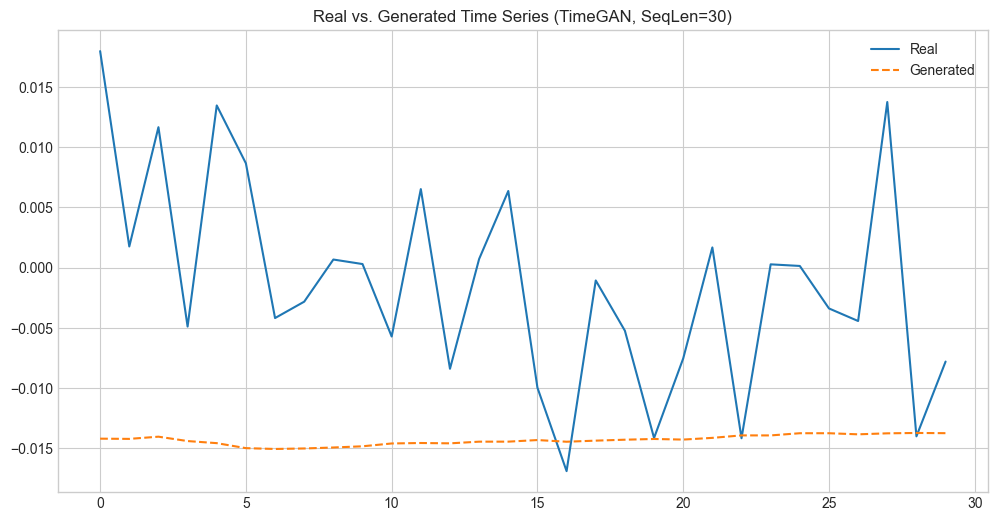

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(real_returns_flat[:SEQUENCE_LENGTH], label='Real')
ax.plot(generated_returns_flat[:SEQUENCE_LENGTH], label='Generated', linestyle='--')
ax.legend()
ax.set_title(f'Real vs. Generated Time Series (TimeGAN, SeqLen={SEQUENCE_LENGTH})')
plt.show()

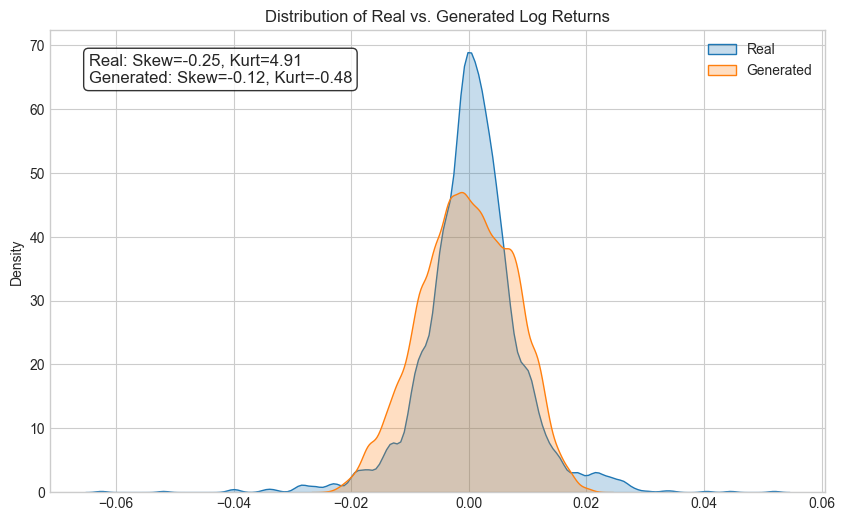

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(real_returns_flat, ax=ax, label='Real', fill=True, clip=(-0.1, 0.1)) # Clip the range for a better view
sns.kdeplot(generated_returns_flat, ax=ax, label='Generated', fill=True, clip=(-0.1, 0.1))
real_kurt, real_skew = kurtosis(real_returns_flat), skew(real_returns_flat)
gen_kurt, gen_skew = kurtosis(generated_returns_flat), skew(generated_returns_flat)
ax.text(0.05, 0.95, f'Real: Skew={real_skew:.2f}, Kurt={real_kurt:.2f}\nGenerated: Skew={gen_skew:.2f}, Kurt={gen_kurt:.2f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.set_title('Distribution of Real vs. Generated Log Returns')
ax.legend()
plt.show()

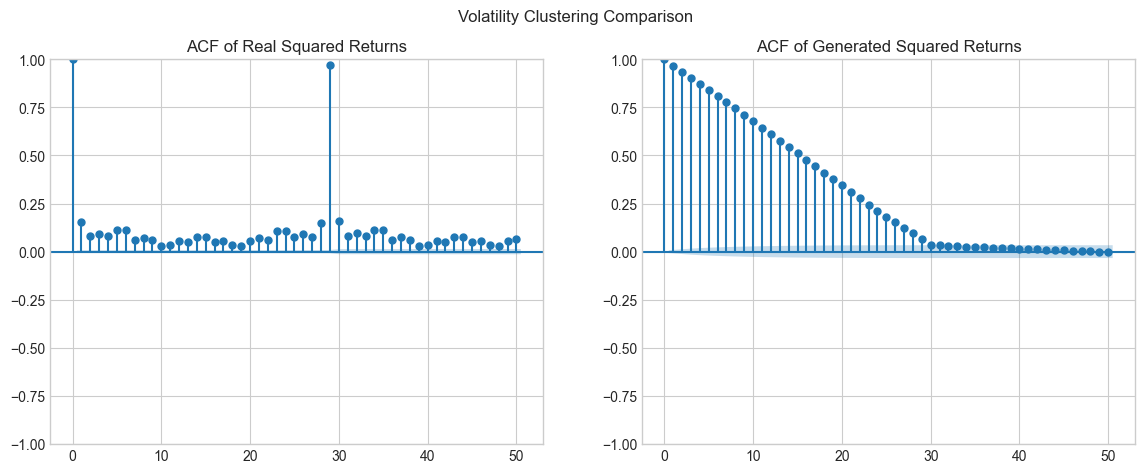

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(real_returns_flat**2, lags=50, ax=axes[0], title='ACF of Real Squared Returns')
plot_acf(generated_returns_flat**2, lags=50, ax=axes[1], title='ACF of Generated Squared Returns')
plt.suptitle('Volatility Clustering Comparison')
plt.show()

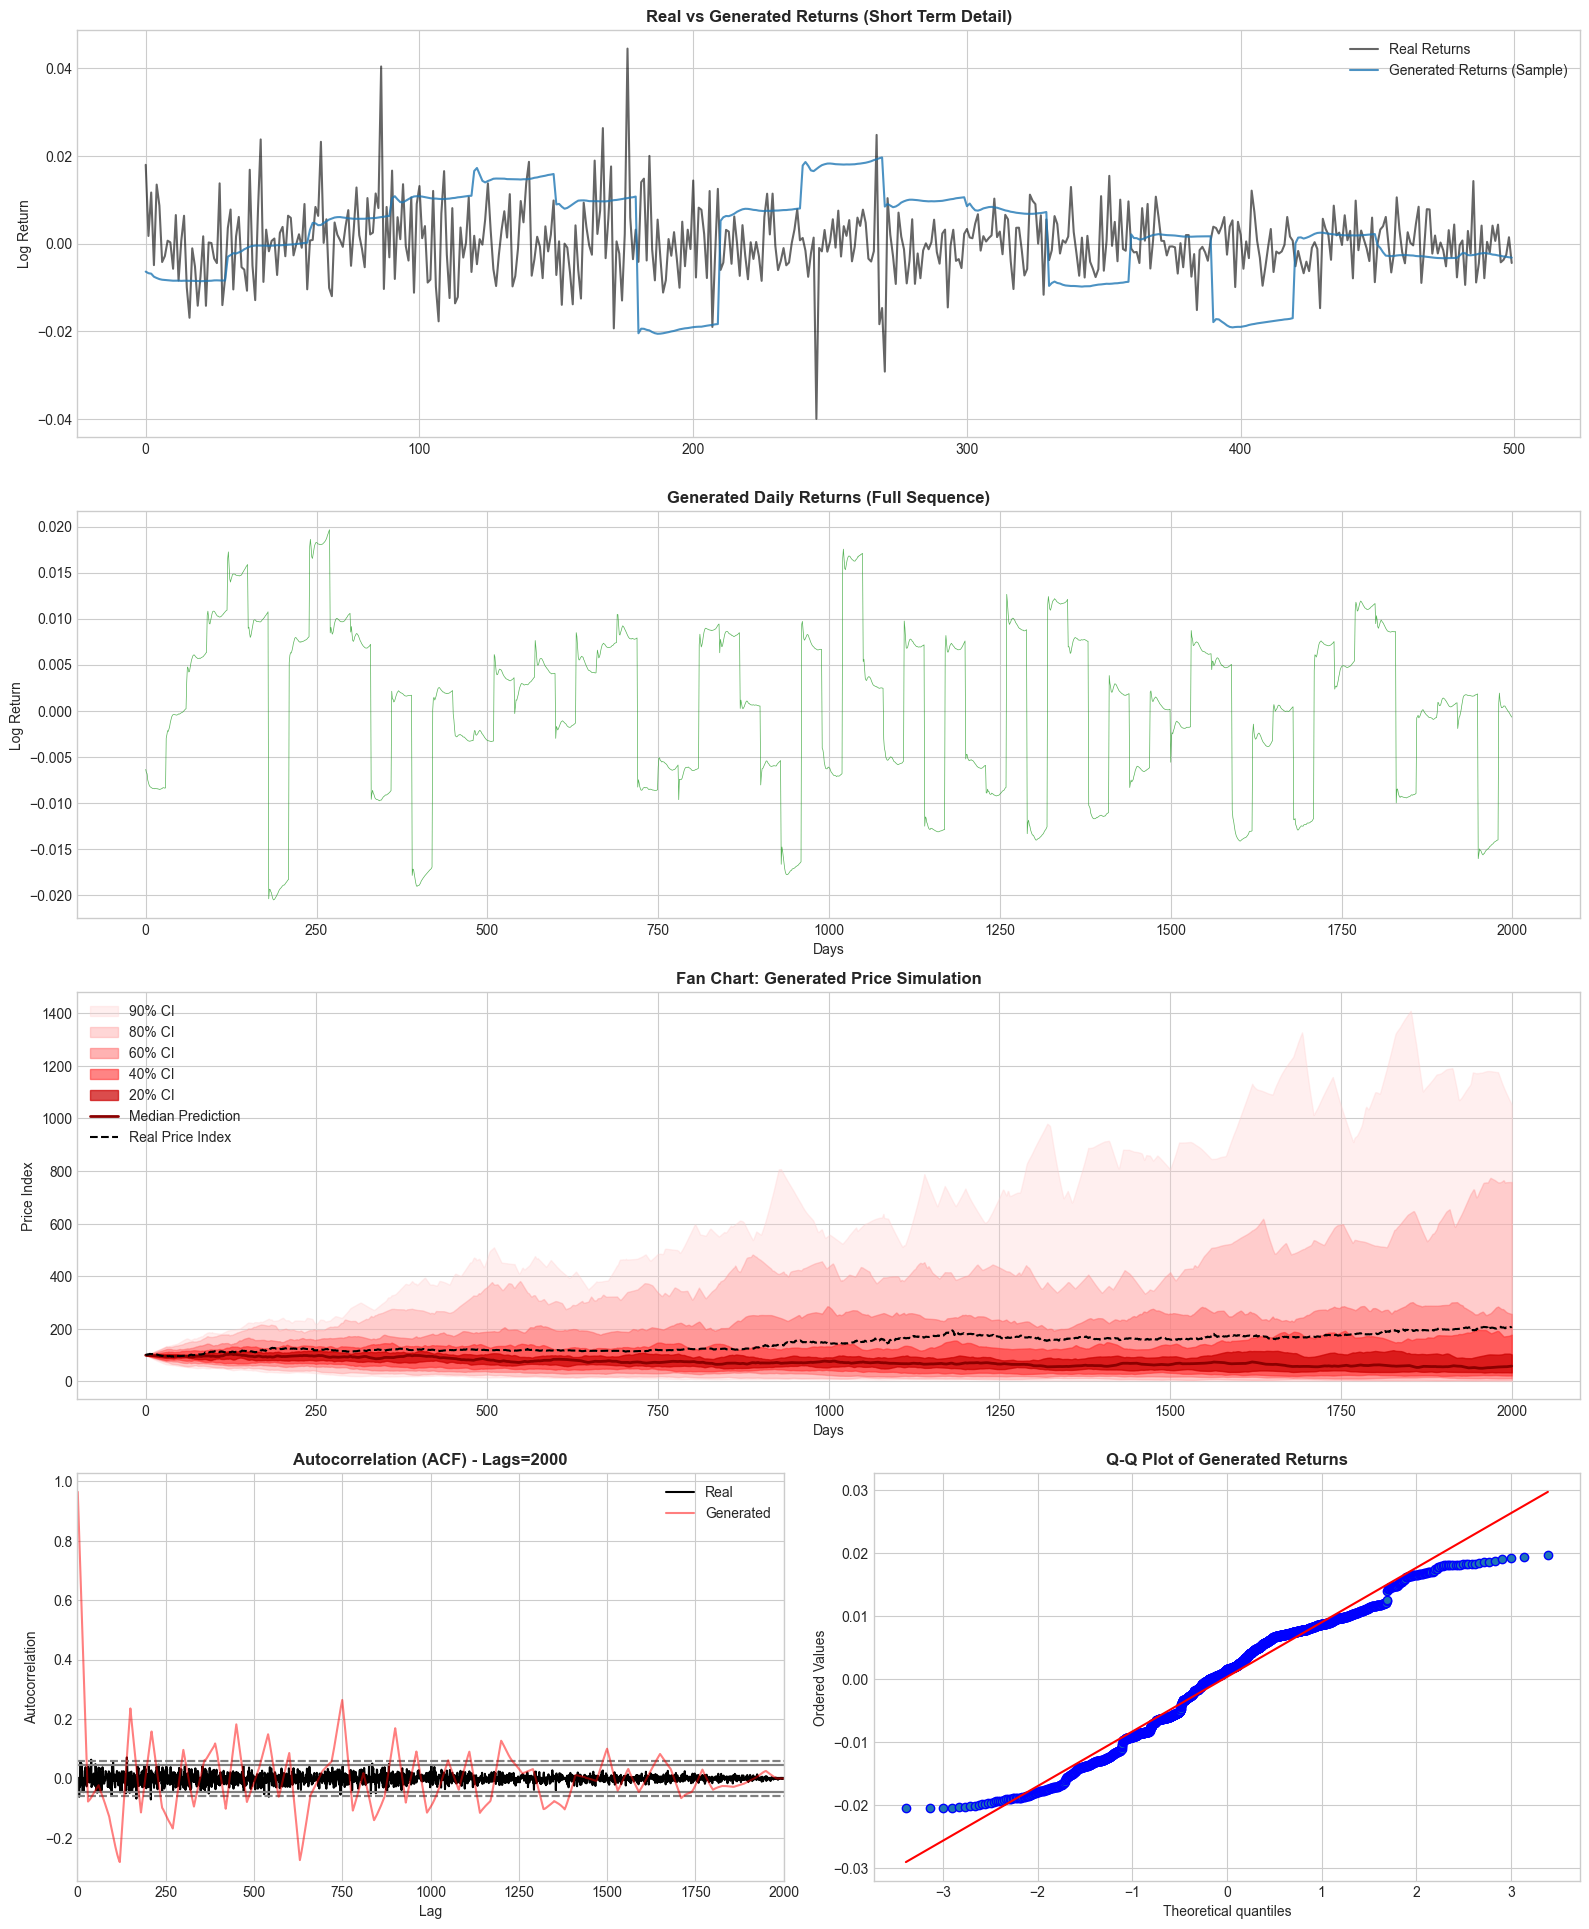

In [38]:
# ==========================================
# Auxiliary function: Safely convert GPU data to CPU for graphics rendering
# ==========================================
def to_cpu_list(data):
    if data is None:
        return []
    
    if isinstance(data, torch.Tensor):
        if data.ndim == 0:
            return [data.item()]
        else:
            return data.detach().cpu().numpy().flatten()
            
    if isinstance(data, list):
        if len(data) == 0: return []
        if isinstance(data[0], torch.Tensor):
            return [x.detach().cpu().item() for x in data]
        return data
        
    if isinstance(data, np.ndarray):
        return data.flatten()
        
    return []

# ==========================================
# 0. Configuration and variable alignment
# ==========================================
S0 = 100

def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns)
    cumulative_returns = np.clip(cumulative_returns, -10, 10)
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

if 'device' not in globals(): device = 'cpu'
if 'NOISE_DIM' not in globals(): NOISE_DIM = 10
if 'SEQUENCE_LENGTH' not in globals(): SEQUENCE_LENGTH = 30
if 'scaler' not in globals():
    print("Warning: The scaler is undefined. Attempting to restore the real data from the dataloader using the default value...")
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(np.random.randn(100, 1)) # Dummy fit

try:
    real_ret_flat = log_returns.flatten()
except NameError:
    print("Attempt to restore the real data from the dataloader...")
    try:
        real_data_list = []
        for batch in dataloader:
            real_data_list.append(batch[0].numpy())
        real_data_arr = np.concatenate(real_data_list, axis=0)
        real_ret_flat = scaler.inverse_transform(real_data_arr.reshape(-1, 1)).flatten()
    except:
        real_ret_flat = np.random.randn(2000) * 0.01

display_len = 2000
real_returns_arr = real_ret_flat[:display_len]
real_price_arr = returns_to_index(real_returns_arr, S0)

# ==========================================
# 2. Generate multiple simulation paths
# ==========================================
n_simulations = 100
sim_prices = []
sim_returns = []

if 'generator' in globals() and 'supervisor' in globals() and 'recovery' in globals():
    generator.eval()
    supervisor.eval()
    recovery.eval()
    
    n_segments = display_len // SEQUENCE_LENGTH + 1
    
    with torch.no_grad():
        for _ in range(n_simulations):
            path_segments = []
            for _ in range(n_segments):
                Z = torch.rand(1, SEQUENCE_LENGTH, NOISE_DIM).to(device)
                E_hat = generator(Z)
                H_hat = supervisor(E_hat)
                fake_data_norm = recovery(H_hat).cpu().numpy().reshape(-1, 1)
                fake_ret = scaler.inverse_transform(fake_data_norm).flatten()
                path_segments.append(fake_ret)
            
            full_path = np.concatenate(path_segments)[:display_len]
            sim_returns.append(full_path)
            sim_prices.append(returns_to_index(full_path, S0))
            
    sim_prices = np.array(sim_prices)
    sim_returns = np.array(sim_returns)
    
    percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
    fan_data = np.percentile(sim_prices, percentiles, axis=0)
    median_path = fan_data[5]
else:
    print("Error: Model variables are not defined. Skip the generation step.")
    median_path = np.zeros(display_len) + S0
    fan_data = np.zeros((11, display_len)) + S0
    sim_returns = [np.zeros(display_len)]


# ==========================================
# 3. plot
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24))

# ---  3: Real vs Generated Return (Zoom In) ---
ax3 = plt.subplot(5, 1, 2)
zoom = min(500, len(real_returns_arr))
plt.plot(real_returns_arr[:zoom], label='Real Returns', color='black', alpha=0.6, linewidth=1.5)
plt.plot(sim_returns[0][:zoom], label='Generated Returns (Sample)', color='#1f77b4', alpha=0.8, linewidth=1.5)
plt.title("Real vs Generated Returns (Short Term Detail)", fontsize=12, fontweight='bold')
plt.ylabel("Log Return")
plt.legend()

# ---  4: Generated Daily Return (Full Sequence) ---
ax4 = plt.subplot(5, 1, 3)
plt.plot(sim_returns[0], color='#2ca02c', alpha=0.8, linewidth=0.5)
plt.title("Generated Daily Returns (Full Sequence)", fontsize=12, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Log Return")

# ---  5:  Fan Chart ---
ax5 = plt.subplot(5, 1, 4)
x_idx = range(len(median_path))
plt.fill_between(x_idx, fan_data[0], fan_data[10], color='#ffcccc', alpha=0.3, label='90% CI')
plt.fill_between(x_idx, fan_data[1], fan_data[9],  color='#ff9999', alpha=0.4, label='80% CI')
plt.fill_between(x_idx, fan_data[2], fan_data[8],  color='#ff6666', alpha=0.5, label='60% CI')
plt.fill_between(x_idx, fan_data[3], fan_data[7],  color='#ff3333', alpha=0.6, label='40% CI')
plt.fill_between(x_idx, fan_data[4], fan_data[6],  color='#cc0000', alpha=0.7, label='20% CI')
plt.plot(x_idx, median_path, color='darkred', linewidth=2, label='Median Prediction')
r_len = min(len(real_price_arr), len(x_idx))
plt.plot(x_idx[:r_len], real_price_arr[:r_len], color='black', linewidth=1.5, linestyle='--', label='Real Price Index')
plt.title("Fan Chart: Generated Price Simulation", fontsize=12, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Price Index")
plt.legend(loc='upper left')

# ---  6 & 7: ACF & Q-Q Plot ---
ax6 = plt.subplot(5, 2, 9)
pd.plotting.autocorrelation_plot(real_returns_arr, label='Real', color='black', ax=ax6)
pd.plotting.autocorrelation_plot(sim_returns[0], label='Generated', color='red', alpha=0.5, ax=ax6)
ax6.set_title("Autocorrelation (ACF) - Lags=2000", fontsize=12, fontweight='bold')
ax6.set_xlim([0, 2000])
ax6.legend()

ax7 = plt.subplot(5, 2, 10)
stats.probplot(sim_returns[0], dist="norm", plot=ax7)
ax7.get_lines()[0].set_markerfacecolor('#1f77b4')
ax7.get_lines()[1].set_color('red')
ax7.set_title("Q-Q Plot of Generated Returns", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
# --- Evaluation and visualization ---

# Set models to evaluation mode
generator.eval()
supervisor.eval()
recovery.eval()

# Generate normalized returns using the trained model
with torch.no_grad():
    Z = torch.rand(len(real_sequences), SEQUENCE_LENGTH, NOISE_DIM).to(device)
    E_hat = generator(Z)
    H_hat = supervisor(E_hat)
    generated_normalized = recovery(H_hat).cpu().numpy()  # [N, T, 1]

# Denormalize returns to original log-return space
generated_returns = scaler.inverse_transform(
    generated_normalized.reshape(-1, 1)
).reshape(-1)

real_returns_flat = scaler.inverse_transform(
    real_sequences.cpu().numpy().reshape(-1, 1)
).reshape(-1)

generated_returns_flat = generated_returns.flatten()
real_returns_flat = real_returns_flat.flatten()

# Function to unify conversion of Tensor, List of Tensors, or Array to CPU list
def to_cpu_list(data):
    """Unify conversion of Tensor, List of Tensors, or Array to CPU list"""
    if data is None:
        return []
    
    # If it's a single Tensor (scalar)
    if isinstance(data, torch.Tensor):
        if data.ndim == 0:
            return [data.item()]
        else:
            return data.detach().cpu().numpy().flatten()
            
    # If it's a list
    if isinstance(data, list):
        if len(data) == 0: return []
        # Check if list elements are Tensors
        if isinstance(data[0], torch.Tensor):
            return [x.detach().cpu().item() for x in data]
        return data
        
    # If it's a Numpy array
    if isinstance(data, np.ndarray):
        return data.flatten()
        
    return []

# Configuration and variable alignment
S0 = 100

def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns)
    cumulative_returns = np.clip(cumulative_returns, -10, 10)
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

# Check necessary variables (prevent crashes)
if 'device' not in globals(): device = 'cpu'
if 'NOISE_DIM' not in globals(): NOISE_DIM = 10
if 'SEQUENCE_LENGTH' not in globals(): SEQUENCE_LENGTH = 30
if 'scaler' not in globals():
    print("Warning: scaler is not defined, using default values")
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(np.random.randn(100, 1))  # Dummy fit

# Get real data
try:
    real_ret_flat = log_returns.flatten()
except NameError:
    print("Trying to restore real data from dataloader...")
    try:
        real_data_list = []
        for batch in dataloader:
            real_data_list.append(batch[0].numpy())
        real_data_arr = np.concatenate(real_data_list, axis=0)
        real_ret_flat = scaler.inverse_transform(real_data_arr.reshape(-1, 1)).flatten()
    except:
        real_ret_flat = np.random.randn(2000) * 0.01

display_len = 2000
real_returns_arr = real_ret_flat[:display_len]
real_price_arr = returns_to_index(real_returns_arr, S0)

# Generate multiple simulation paths
n_simulations = 100
sim_prices = []
sim_returns = []

# Ensure models exist and are in evaluation mode
if 'generator' in globals() and 'supervisor' in globals() and 'recovery' in globals():
    generator.eval()
    supervisor.eval()
    recovery.eval()
    
    n_segments = display_len // SEQUENCE_LENGTH + 1
    
    with torch.no_grad():
        for _ in range(n_simulations):
            path_segments = []
            for _ in range(n_segments):
                Z = torch.rand(1, SEQUENCE_LENGTH, NOISE_DIM).to(device)
                E_hat = generator(Z)
                H_hat = supervisor(E_hat)
                fake_data_norm = recovery(H_hat).cpu().numpy().reshape(-1, 1)
                fake_ret = scaler.inverse_transform(fake_data_norm).flatten()
                path_segments.append(fake_ret)
            
            full_path = np.concatenate(path_segments)[:display_len]
            sim_returns.append(full_path)
            sim_prices.append(returns_to_index(full_path, S0))
            
    sim_prices = np.array(sim_prices)
    sim_returns = np.array(sim_returns)
    
    # Calculate percentiles
    percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
    fan_data = np.percentile(sim_prices, percentiles, axis=0)
    median_path = fan_data[5]
else:
    print("Error: Model variables not defined, skipping generation step.")
    median_path = np.zeros(display_len) + S0
    fan_data = np.zeros((11, display_len)) + S0
    sim_returns = [np.zeros(display_len)]

# Calculate volatility measures
real_returns_series = pd.Series(real_returns_flat)
volatility_real = real_returns_series.rolling(window=5).std().fillna(0).values

generated_returns_series = pd.Series(generated_returns_flat)
volatility_fake = generated_returns_series.rolling(window=5).std().fillna(0).values

In [40]:
# Generate descriptive statistics table
timegan_returns = generated_returns_flat.reshape(-1)
timegan_series = pd.Series(timegan_returns, name="TimeGAN")
timegan_table = timegan_series.describe().to_frame()
print(timegan_table)

            TimeGAN
count  71310.000000
mean      -0.000188
std        0.007945
min       -0.026673
25%       -0.005646
50%        0.000273
75%        0.005609
max        0.022150


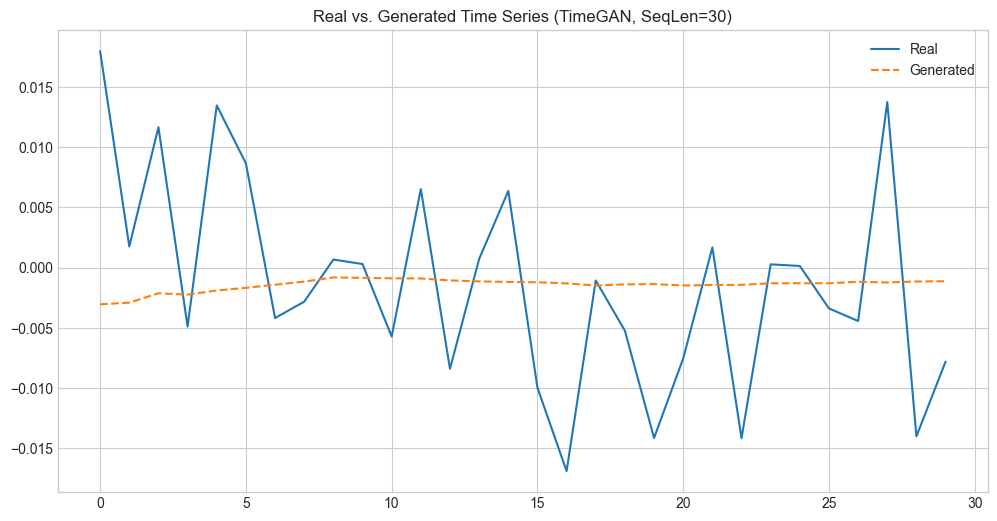

In [41]:
# Plot 1: Real vs. Generated Time Series
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(real_returns_flat[:SEQUENCE_LENGTH], label='Real')
ax1.plot(generated_returns_flat[:SEQUENCE_LENGTH], label='Generated', linestyle='--')
ax1.legend()
ax1.set_title(f'Real vs. Generated Time Series (TimeGAN, SeqLen={SEQUENCE_LENGTH})')
plt.show()


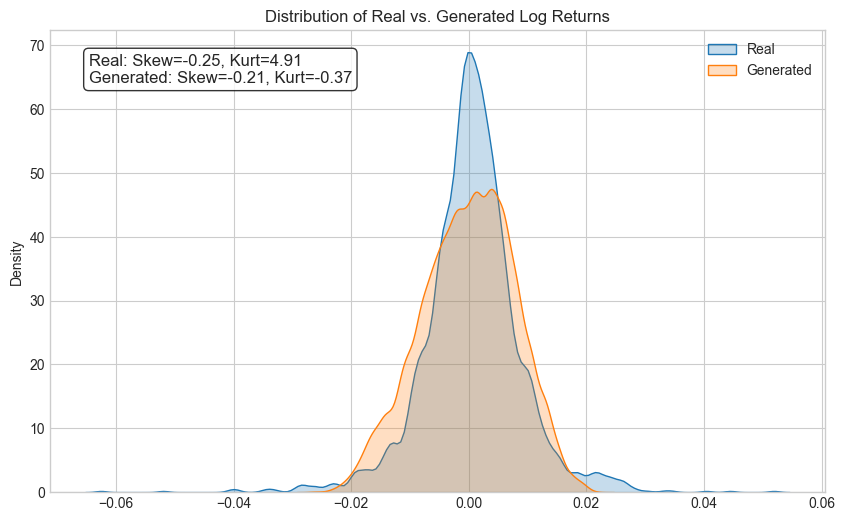

In [42]:
# Plot 2: Distribution of Real vs. Generated Log Returns
fig2, ax2 = plt.subplots(figsize=(10, 6))
sns.kdeplot(real_returns_flat, ax=ax2, label='Real', fill=True, clip=(-0.1, 0.1))
sns.kdeplot(generated_returns_flat, ax=ax2, label='Generated', fill=True, clip=(-0.1, 0.1))
real_kurt, real_skew = kurtosis(real_returns_flat), skew(real_returns_flat)
gen_kurt, gen_skew = kurtosis(generated_returns_flat), skew(generated_returns_flat)
ax2.text(0.05, 0.95, f'Real: Skew={real_skew:.2f}, Kurt={real_kurt:.2f}\nGenerated: Skew={gen_skew:.2f}, Kurt={gen_kurt:.2f}', 
        transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.set_title('Distribution of Real vs. Generated Log Returns')
ax2.legend()
plt.show()


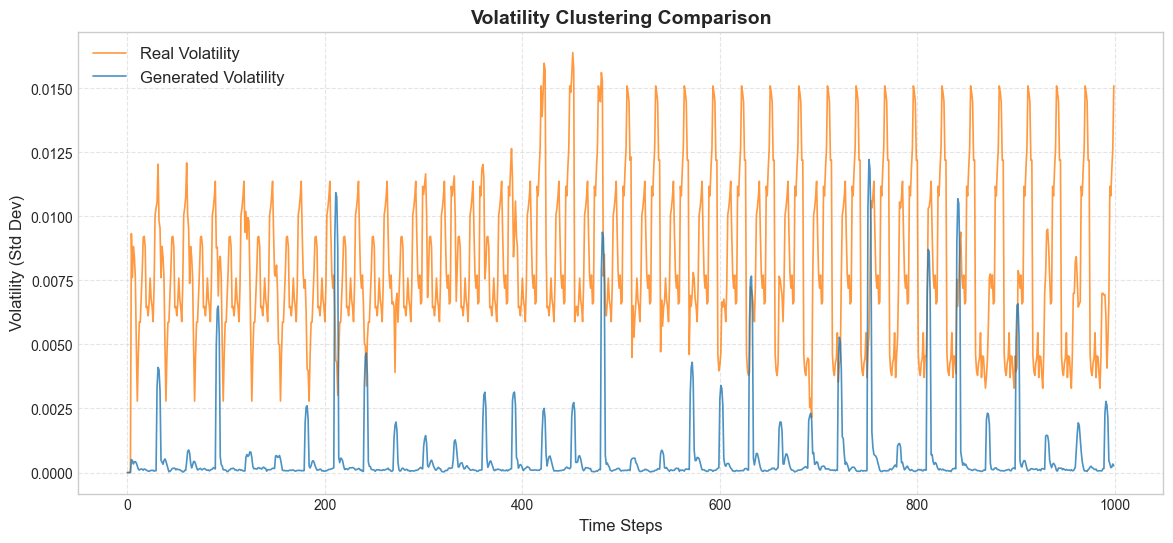

In [43]:
# Plot 3: Volatility Clustering Comparison
plt.figure(figsize=(14, 6))
plt.plot(volatility_real[:1000], label='Real Volatility', color='#ff7f0e', alpha=0.8, linewidth=1.2)
plt.plot(volatility_fake[:1000], label='Generated Volatility', color='#1f77b4', alpha=0.8, linewidth=1.2)
plt.title(f'Volatility Clustering Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Volatility (Std Dev)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()


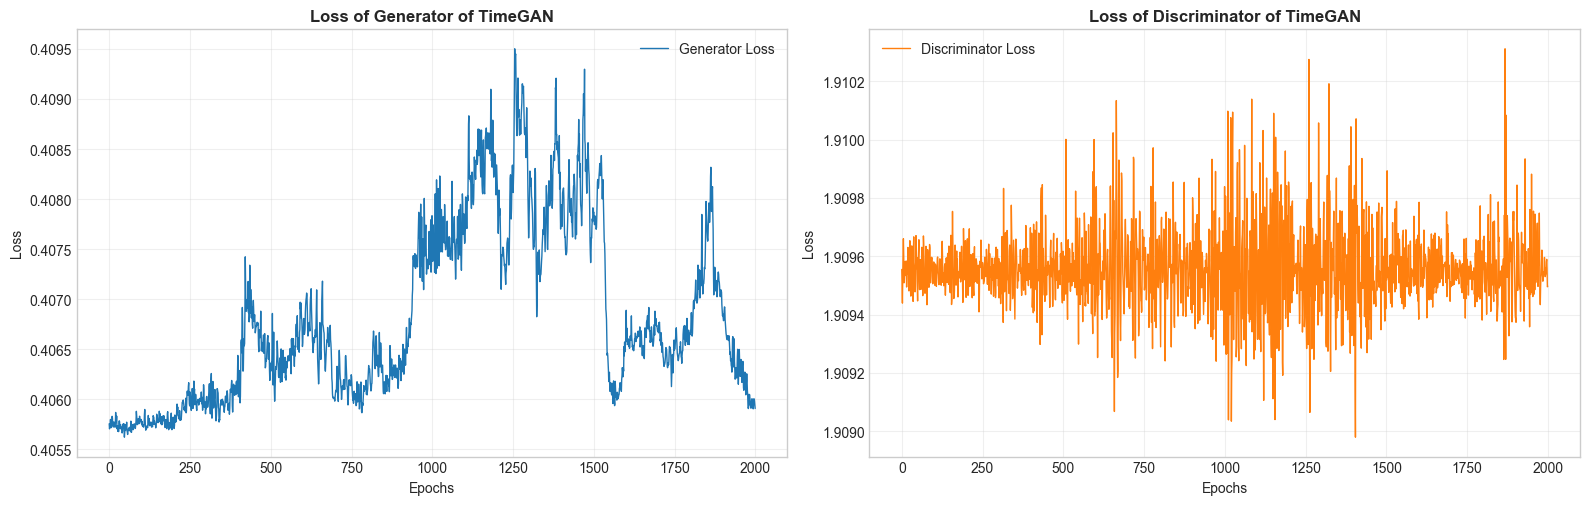

In [51]:
import matplotlib.pyplot as plt

# 设置绘图样式
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 

# 绘制训练损失曲线
ax1 = plt.subplot(5, 2, 1)
plt.plot(G_losses, label='Generator Loss', color='#1f77b4', linewidth=1)
plt.title("Loss of Generator of TimeGAN", fontsize=12, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(5, 2, 2)
plt.plot(D_losses, label='Discriminator Loss', color='#ff7f0e', linewidth=1)
plt.title("Loss of Discriminator of TimeGAN", fontsize=12, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 可以继续添加其他图表...

plt.tight_layout()
plt.show()